# **1. Data Prep**

**1: Imports & Configuration**


In [1]:


!pip install -q albumentations==1.3.1
!pip install -q timm


# Imports

import os
import torch
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2
from pathlib import Path
import random

# Configuration du device (GPU)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation du device : {device}")

# random seed

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything()

Utilisation du device : cuda


**2: Téléchargement du Dataset**

In [2]:

from google.colab import files
print("Veuillez uploader votre fichier kaggle.json :")
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

print("Téléchargement du dataset...")
!kaggle datasets download -d iarunava/cell-images-for-detecting-malaria
!unzip -q cell-images-for-detecting-malaria.zip
print("Dataset dézippé avec succès !")



Veuillez uploader votre fichier kaggle.json :


Saving kaggle.json to kaggle (4).json
Téléchargement du dataset...
Dataset URL: https://www.kaggle.com/datasets/iarunava/cell-images-for-detecting-malaria
License(s): unknown
cell-images-for-detecting-malaria.zip: Skipping, found more recently modified local copy (use --force to force download)
replace cell_images/Parasitized/C100P61ThinF_IMG_20150918_144104_cell_162.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
Dataset dézippé avec succès !



**3: Organisation du chemin & Split**

In [3]:
DATA_DIR = Path("cell_images")


parasitized = list(DATA_DIR.glob('Parasitized/*.png'))
uninfected = list(DATA_DIR.glob('Uninfected/*.png'))

df_parasitized = pd.DataFrame({'path': parasitized, 'label': 1})
df_uninfected = pd.DataFrame({'path': uninfected, 'label': 0})


df = pd.concat([df_parasitized, df_uninfected], axis=0).reset_index(drop=True)
df['path'] = df['path'].astype(str)

print(f"Total images : {len(df)}")
print(f"Infectées : {len(df_parasitized)} | Saines : {len(df_uninfected)}")

# SPLIT

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=42)

print(f"Train size : {len(train_df)}")
print(f"Val size   : {len(val_df)}")
print(f"Test size  : {len(test_df)}")

Total images : 27558
Infectées : 13779 | Saines : 13779
Train size : 22046
Val size   : 2756
Test size  : 2756


**4: Malaria Dataset**

In [4]:
class MalariaDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        image_path = row['path']
        label = row['label']

        # Lecture de l'image avec OpenCV
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']

        return image, torch.tensor(label, dtype=torch.float32)




 **5: Data Augmentation & DataLoaders**

In [5]:

import torch.nn as nn
import torch.optim as optim
from tqdm.notebook import tqdm
from albumentations.pytorch import ToTensorV2



IMG_SIZE = 224
BATCH_SIZE = 32
NUM_EPOCHS = 12
NUM_WORKERS = 2


# -----Data Augmentation
train_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=30, p=0.5),
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.3),
    A.CoarseDropout(max_holes=8, max_height=16, max_width=16, p=0.2), # Très important
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

val_transforms = A.Compose([
    A.Resize(IMG_SIZE, IMG_SIZE),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
])

#----DataLoaders

train_dataset = MalariaDataset(train_df, transform=train_transforms)
val_dataset = MalariaDataset(val_df, transform=val_transforms)
test_dataset = MalariaDataset(test_df, transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print("DataLoaders prêts !")

DataLoaders prêts !


# **2. Modèle & Entrainement**



In [14]:


import timm
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class MalariaNetPro(nn.Module):
    def __init__(self, model_name='efficientnet_b0', pretrained=True):
        super(MalariaNetPro, self).__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained)

        in_features = self.backbone.classifier.in_features

        self.backbone.classifier = nn.Identity()
        self.backbone.global_pool = nn.Identity()

        self.gap = nn.AdaptiveAvgPool2d(1)

        self.head = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features, 1)
        )

    def forward(self, x):
        features = self.backbone.forward_features(x)
        x = self.gap(features)
        x = x.view(x.size(0), -1)
        return self.head(x)

model = MalariaNetPro().to(DEVICE)


criterion = nn.BCEWithLogitsLoss()

def train_one_epoch(loader, model, optimizer, scaler):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(loader, leave=False)
    for images, labels in loop:
        images, labels = images.to(DEVICE), labels.to(DEVICE).unsqueeze(1)

        with torch.amp.autocast('cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        predicted = (torch.sigmoid(outputs) > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        loop.set_postfix(loss=loss.item(), acc=correct/total)

    return running_loss / len(loader), correct / total

def validate(loader, model):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE).unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float()
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return running_loss / len(loader), correct / total


history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# --- PHASE 1  ---
print("\n PHASE 1 : WarmUp ")


for param in model.backbone.parameters():
    param.requires_grad = False

scaler = torch.cuda.amp.GradScaler()
optimizer = optim.AdamW(model.head.parameters(), lr=1e-3, weight_decay=0.01)

for epoch in range(3):
    train_loss, train_acc = train_one_epoch(train_loader, model, optimizer, scaler)
    val_loss, val_acc = validate(val_loader, model)
    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} (Warmup)")


# --- PHASE 2 : FINE-TUNING ---
print("\n PHASE 2 : Fine-Tuning ")


for param in model.backbone.parameters():
    param.requires_grad = True


optimizer = optim.AdamW(model.parameters(), lr=5e-5, weight_decay=0.01)

scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=9)

for epoch in range(9):
    train_loss, train_acc = train_one_epoch(train_loader, model, optimizer, scaler)
    val_loss, val_acc = validate(val_loader, model)
    scheduler.step()

    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    print(f"Epoch {epoch+4} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | Val Loss: {val_loss:.4f}")


    if val_acc > 0.965:
        torch.save(model.state_dict(), f'model_best_epoch_{epoch+4}.pth')

print("\n Terminé ! ")


 PHASE 1 : WarmUp 


/tmp/ipython-input-1835113257.py:87: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 1 | Train Acc: 0.8798 | Val Acc: 0.9271 (Warmup)


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 2 | Train Acc: 0.8999 | Val Acc: 0.9260 (Warmup)


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 3 | Train Acc: 0.9008 | Val Acc: 0.9318 (Warmup)

 PHASE 2 : Fine-Tuning 


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 4 | Train Acc: 0.9517 | Val Acc: 0.9623 | Val Loss: 0.1314


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 5 | Train Acc: 0.9640 | Val Acc: 0.9659 | Val Loss: 0.1239


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 6 | Train Acc: 0.9708 | Val Acc: 0.9670 | Val Loss: 0.1083


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 7 | Train Acc: 0.9719 | Val Acc: 0.9670 | Val Loss: 0.1173


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 8 | Train Acc: 0.9768 | Val Acc: 0.9663 | Val Loss: 0.1137


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 9 | Train Acc: 0.9765 | Val Acc: 0.9702 | Val Loss: 0.1234


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 10 | Train Acc: 0.9789 | Val Acc: 0.9695 | Val Loss: 0.1118


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 11 | Train Acc: 0.9801 | Val Acc: 0.9702 | Val Loss: 0.1116


  0%|          | 0/689 [00:00<?, ?it/s]

Epoch 12 | Train Acc: 0.9802 | Val Acc: 0.9710 | Val Loss: 0.1028

 Terminé ! 


# **4. visualisation des résultats**

1: Courbes Accuracy & Loss

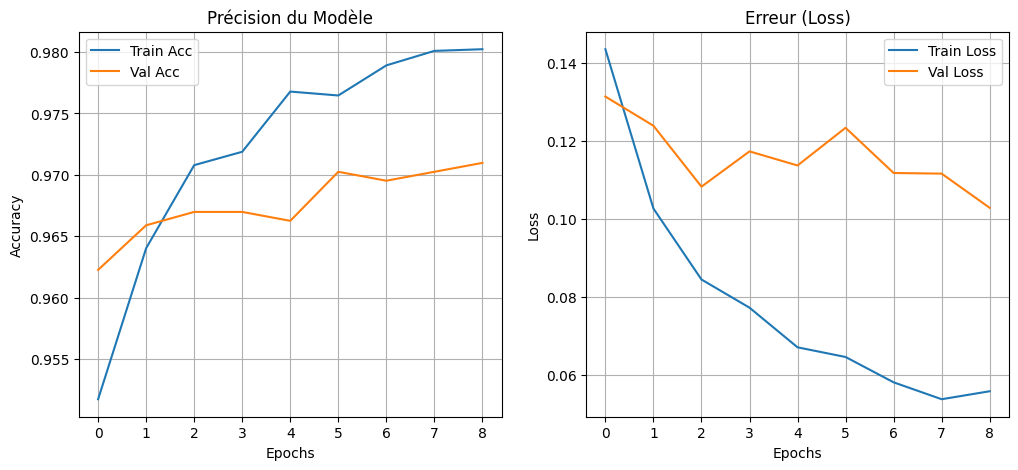

In [15]:

plt.figure(figsize=(12, 5))

# Courbe Accuracy
plt.subplot(1, 2, 1)
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.title('Précision du Modèle')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Courbe Loss
plt.subplot(1, 2, 2)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Val Loss')
plt.title('Erreur (Loss)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.show()

2: Matrice de Confusion & Courbe ROC


🔍 Analyse du jeu de validation en cours...


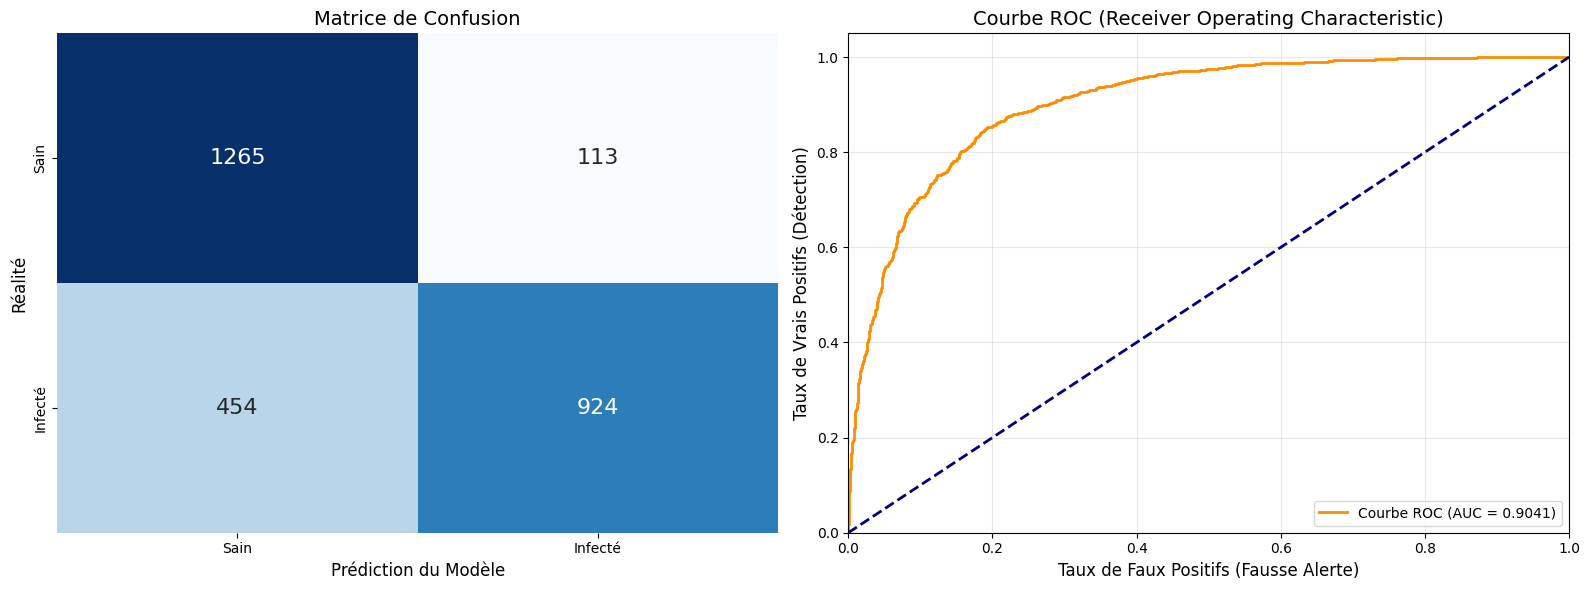


📋 Rapport de Classification :
              precision    recall  f1-score   support

        Sain       0.74      0.92      0.82      1378
     Infecté       0.89      0.67      0.77      1378

    accuracy                           0.79      2756
   macro avg       0.81      0.79      0.79      2756
weighted avg       0.81      0.79      0.79      2756



In [23]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

y_true = []
y_probs = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(DEVICE)

        outputs = model(images)
        probs = torch.sigmoid(outputs)

        preds = (probs > 0.5).float()

        y_true.extend(labels.numpy())
        y_probs.extend(probs.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())


y_true = np.array(y_true)
y_probs = np.array(y_probs)
y_pred = np.array(y_pred)


plt.figure(figsize=(16, 6))

# --- MATRICE DE CONFUSION ---
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Sain', 'Infecté'],
            yticklabels=['Sain', 'Infecté'], annot_kws={"size": 16})
plt.xlabel('Prédiction du Modèle', fontsize=12)
plt.ylabel('Réalité', fontsize=12)
plt.title('Matrice de Confusion', fontsize=14)

# --- COURBE ROC ---
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Courbe ROC (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taux de Faux Positifs (Fausse Alerte)', fontsize=12)
plt.ylabel('Taux de Vrais Positifs (Détection)', fontsize=12)
plt.title('Courbe ROC (Receiver Operating Characteristic)', fontsize=14)
plt.legend(loc="lower right")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 3. RAPPORT
print("\n📋 Rapport de Classification :")
print(classification_report(y_true, y_pred, target_names=['Sain', 'Infecté']))

# **5. Interface Gradio**

In [21]:
!pip install gradio

In [22]:
import gradio as gr




# ----BACKEND

def predict_malaria_pro(input_image):
    if input_image is None:
        return None

    image = cv2.resize(input_image, (224, 224))

    image = image.astype(np.float32) / 255.0
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = (image - mean) / std

    image = image.transpose(2, 0, 1)

    image_tensor = torch.tensor(image).unsqueeze(0).float().to(device)

    model.eval()
    with torch.no_grad():
        output = model(image_tensor)
        prob_parasitized = torch.sigmoid(output).item()

    return {
        "Infecté (Malaria) 🦠": prob_parasitized,
        "Sain (Healthy) 🩸": 1 - prob_parasitized
    }

# ---FRONTEND

medical_theme = gr.themes.Soft(
    primary_hue="cyan",
    secondary_hue="slate",
).set(
    body_background_fill="*secondary_50",
    block_background_fill="white",
    button_primary_background_fill="*primary_600",
    button_primary_text_color="white",
)

try:
    ex_malade = str(df_parasitized.iloc[10]['path'])
    ex_sain = str(df_uninfected.iloc[10]['path'])
    example_images = [[ex_malade], [ex_sain]]
except:
    example_images = None

with gr.Blocks(theme=medical_theme, title="Malaria AI Diagnostician") as demo:

    gr.Markdown(
        """
        # 🔬 AI-Powered Malaria Detector
        ### Système d'aide au diagnostic rapide par Deep Learning.
        Chargez une image de frottis sanguin (microscope) pour détecter la présence du parasite *Plasmodium*.
        """
    )

    with gr.Row():
        with gr.Column(scale=1):
            image_input = gr.Image(
                type="numpy",
                label="Image Microscope",
                sources=["upload", "clipboard"],
                height=300
            )
            analyze_btn = gr.Button("Lancer le Diagnostic ⚡", variant="primary", size="lg")

        with gr.Column(scale=1):
            label_output = gr.Label(num_top_classes=2, label="Résultat de l'IA")

    if example_images:
        gr.Markdown("### 🧪 Exemples de test (Cliquez pour charger)")
        gr.Examples(
            examples=example_images,
            inputs=image_input,
            outputs=label_output,
            fn=predict_malaria_pro,
            run_on_click=True,
            label="Images de test issues du dataset"
        )

    analyze_btn.click(
        fn=predict_malaria_pro,
        inputs=image_input,
        outputs=label_output,
        api_name="predict"
    )

print("🚀 Relancement de l'interface corrigée...")
demo.launch(share=True, debug=False)

/tmp/ipython-input-2510387329.py:52: DeprecationWarning: The 'theme' parameter in the Blocks constructor will be removed in Gradio 6.0. You will need to pass 'theme' to Blocks.launch() instead.
  with gr.Blocks(theme=medical_theme, title="Malaria AI Diagnostician") as demo:


🚀 Relancement de l'interface corrigée...
Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://2e6bbd4c2f26fae264.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
